## TST *args and **kwargs

Usual values are the ones that appear in the "Attention is all you need" and "A Transformer-based Framework for Multivariate Time Series Representation Learning" papers. 

The default values are the ones selected as a default configuration in the latter.

* c_in: the number of features (aka variables, dimensions, channels) in the time series dataset. dls.var
* c_out: the number of target classes. dls.c
* seq_len: number of time steps in the time series. dls.len
* max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues. Default. None.
* d_model: total dimension of the model (number of features created by the model). Usual values: 128-1024. Default: 128.
* n_heads:  parallel attention heads. Usual values: 8-16. Default: 16.
* d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
* d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
* d_ff: the dimension of the feedforward network model. Usual values: 256-4096. Default: 256.
* dropout: amount of residual dropout applied in the encoder. Usual values: 0.-0.3. Default: 0.1.
* activation: the activation function of intermediate layer, relu or gelu. Default: 'gelu'.
* num_layers: the number of sub-encoder-layers in the encoder. Usual values: 2-8. Default: 3.
* fc_dropout: dropout applied to the final fully connected layer. Usual values: 0-0.8. Default: 0.
* pe: type of positional encoder. Available types: None, 'gauss' (default), 'lin1d', 'exp1d', '2d', 'sincos', 'zeros'. Default: 'gauss'.
* learn_pe: learned positional encoder (True, default) or fixed positional encoder. Default: True.
* flatten: this will flattent the encoder output to be able to apply an mlp type of head. Default=True.
* custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function). Default: None.
* y_range: range of possible y values (used in regression tasks). Default: None
* kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.

## Tips on how to use transformers:

* In general, transformers require a lower lr compared to other time series models when used with the same datasets. It's important to use `learn.lr_find()` to learn what a good lr may be. 

* The paper authors recommend to standardize data by feature. This can be done by adding `TSStandardize(by_var=True` as a batch_tfm when creating the `TSDataLoaders`.

* When using TST with a long time series, you may use `max_w_len` to reduce the memory size and thus avoid gpu issues.`

* In some of the cases I've used it, you may need to increase the dropout > .1 and/ or fc_dropout > 0 in order to achieve a good performance. 

* You may also experiment with other key hyperparameters like d_model, n_layers, n_heads, etc, but I have not seen major difference in my experience. 

In [1]:
from tsai.all import *
computer_setup()

c:\Users\karll\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


# Load data 🔢

In [13]:
##Data needs to be of the format [length, features, sequence]
import sys, os
import pandas as pd

from Preprocessing.preprocessing import preprocessing

df_alpacca = pd.read_csv('Data\Stock\StockBars\AAPL_minute')
df_twelve = pd.read_csv('Data\\twelve_data\AAPL_1min')

df = df_twelve
data = 'twelve'
index = '1min'
CLF = True
buckets = 1
lag = 3
sequence_length = 5

data_train, data_test ,s = preprocessing(df[:10000],
                                         sequence_length = sequence_length, 
                                         lag=lag, 
                                         TSAI = True, 
                                         CLF = CLF, 
                                         data = data, 
                                         index=index,
                                         dif_all=False, 
                                         buckets=buckets)

X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])


print(X.shape, y.shape)

                  min      max
positive_bucket               
0.0             -3.32 -0.00009
1.0              0.00  2.70990
Split full dataset
0.0    5090
1.0    4906
Name: change, dtype: int64
0.0    4578
1.0    4418
Name: change, dtype: int64
0.0    509
1.0    488
Name: change, dtype: int64
torch.Size([9985, 12, 5]) torch.Size([9985])


# TST baseline 🧢

SuggestedLRs(valley=0.00013182566908653826)

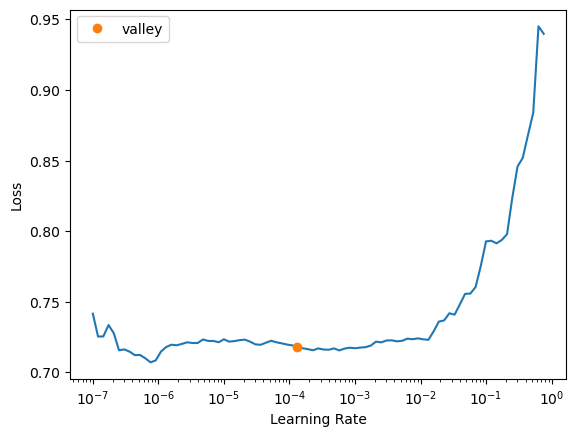

In [38]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = TST(X.shape[1], c_out = buckets*2, seq_len=dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time
0,0.699779,0.709070,0.500504,00:08
1,0.696117,0.692853,0.513595,00:08


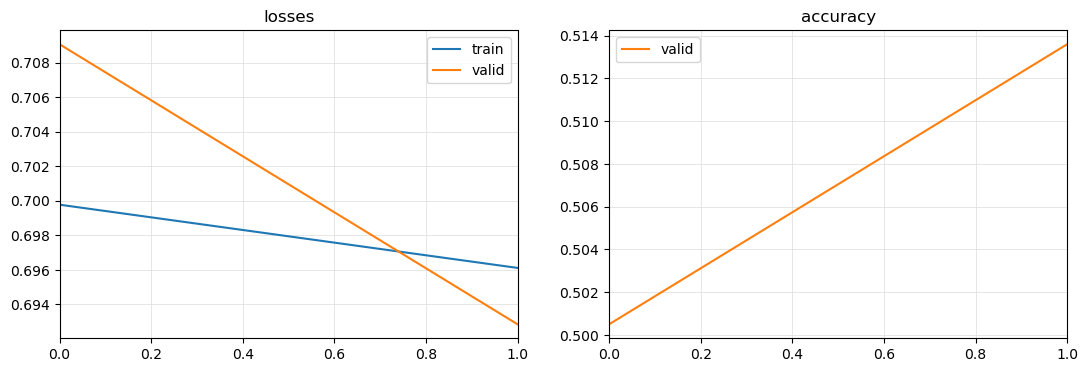


Elapsed time: 18.139403820037842


In [41]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy,  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(2, 8e-3)
print('\nElapsed time:', time.time() - start)

In [48]:
learn.dls[0].c

cm = ClassificationInterpretation.from_learner(learn).confusion_matrix()

AttributeError: vocab

# Parameter tuning

In [38]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    d_model = trial.suggest_categorical('d_model', [32, 64, 128]) # search through all categorical values in the provided list
    n_heads = trial.suggest_categorical('n_heads', [4, 8, 16])
    n_layers = trial.suggest_categorical('n_layers', [2, 4, 8])
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    model = TST(9, 2, dls.len, 
                d_model=d_model, 
                n_heads=n_heads,
                n_layers=n_layers,
                dropout=dropout,
                fc_dropout=fc_dropout,)
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=FastAIPruningCallback(trial))

    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(15, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][3] # return the validation loss value of the last epoch 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=16)

[I 2023-03-02 16:51:43,418] A new study created in memory with name: no-name-7050aacf-0404-41ae-b71d-f3060f546801
[I 2023-03-02 16:54:07,834] Trial 0 finished with value: 0.5697091221809387 and parameters: {'d_model': 128, 'n_heads': 8, 'n_layers': 8, 'dropout': 0.2, 'fc_dropout': 0.0, 'learning_rate': 3.485359047157576e-05}. Best is trial 0 with value: 0.5697091221809387.
[I 2023-03-02 16:55:17,602] Trial 1 finished with value: 0.4824473559856415 and parameters: {'d_model': 64, 'n_heads': 4, 'n_layers': 4, 'dropout': 0.1, 'fc_dropout': 0.0, 'learning_rate': 4.000769241296087e-06}. Best is trial 0 with value: 0.5697091221809387.
[I 2023-03-02 16:57:47,843] Trial 2 finished with value: 0.44834503531455994 and parameters: {'d_model': 128, 'n_heads': 8, 'n_layers': 8, 'dropout': 0.1, 'fc_dropout': 0.1, 'learning_rate': 1.7518653334545196e-06}. Best is trial 0 with value: 0.5697091221809387.
[I 2023-03-02 16:58:35,186] Trial 3 finished with value: 0.570712149143219 and parameters: {'d_mode

# Regression

In [ ]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

SuggestedLRs(valley=0.03981071710586548)

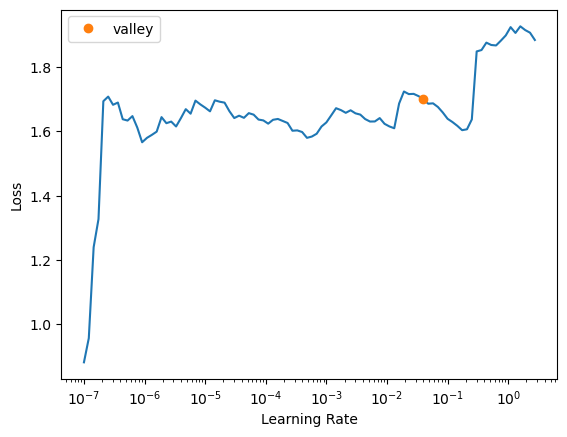

In [13]:
model = TST(dls.vars, dls.c, dls.len)
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.699369,2.021484,0.892381,1.421789,01:34
1,1.663937,2.026996,0.900435,1.423726,01:37
2,1.665581,2.097300,0.947802,1.448206,01:38
3,1.665404,2.020777,0.889225,1.421540,01:38
4,1.641440,2.300154,1.013283,1.516626,01:37
5,1.647513,2.020894,0.890245,1.421582,01:35
6,1.665617,2.021720,0.900991,1.421872,01:35
7,1.626996,2.035539,0.900540,1.426723,01:36
8,1.626784,2.021780,0.891127,1.421893,01:36
9,1.632666,2.018166,0.890780,1.420622,01:42


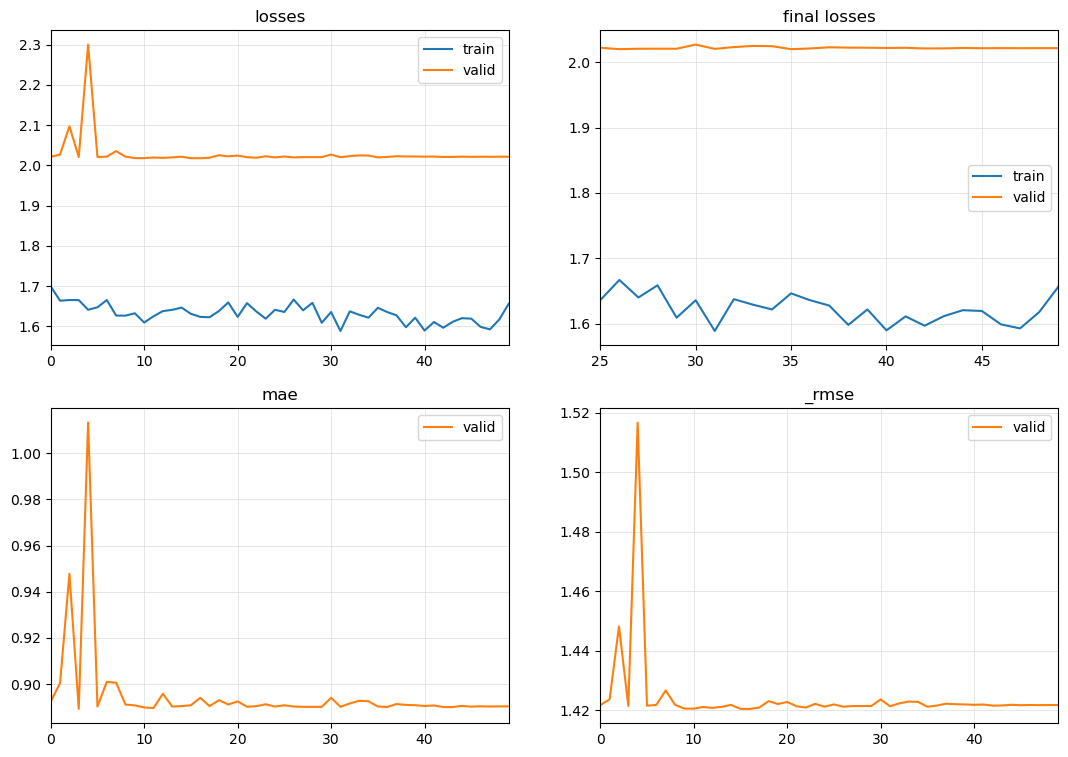


Elapsed time: 4766.765464067459


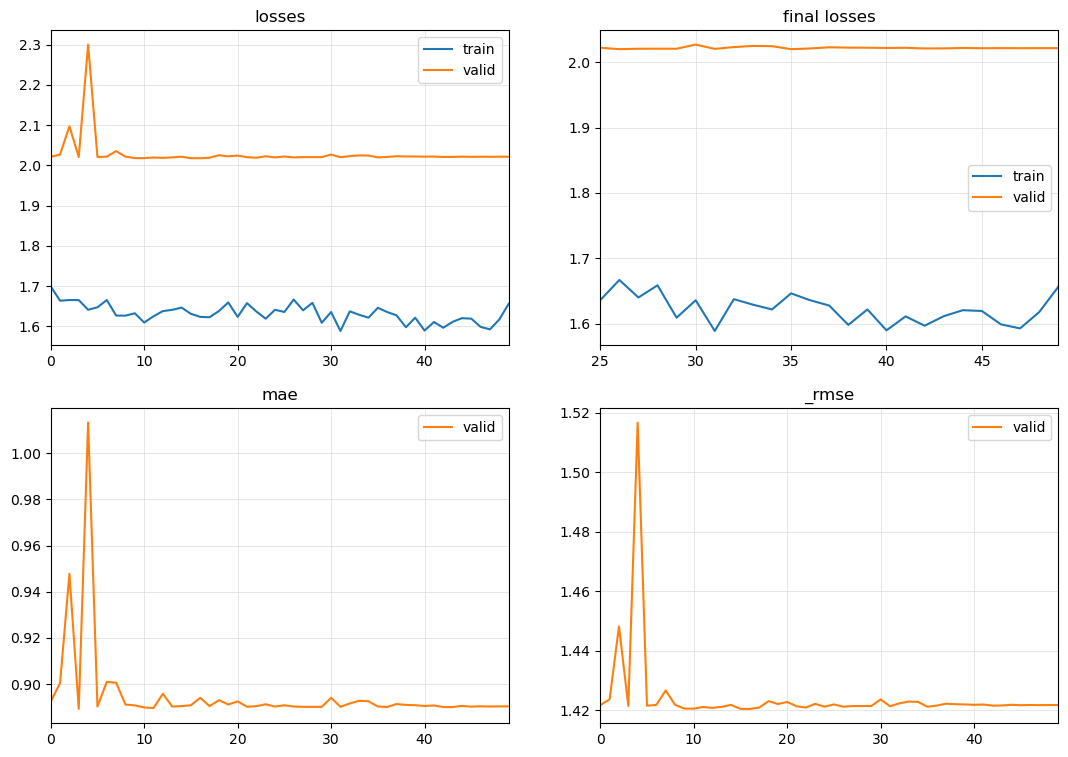

In [14]:
model = TST(dls.vars, dls.c, dls.len)
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
start = time.time()
learn.fit_one_cycle(50, 4e-2)
print('\nElapsed time:', time.time() - start)
learn.plot_metrics()

# How to improve performance with TST? ➕

The model clearly overfits in this task. To try and improve performance I will increase dropout. There are 2 types of dropout in TST: 

* applied to the MHAttention and Feed-Forward layers. Usually 0-0.3. Default: 0.1.

* applied to the fully connected head. Usually 0-0.8. Default: 0.

Let's see what's the impact of these 2 hyperparameters, used independently and combined.

dropout by itself reduces overfit, but it doesn't eliminate it.

It still slightly overfits, although it's much better than the original settings. 

Now let's try both together.

Let's check what happens if we increase dropout a bit more...

This is a great result, beyond InceptionTime and any other the state-of-the-art papers I've seen.

# Conclusion ✅

TST (Time Series Transformer) seems like a great addition to the world of time series models.

The model trains very smoothly and overfitting can be reduced/ eliminated by using dropout.

Also, TST is about 10% faster to train that InceptionTime.
Here's all the code you need to train a transformer model with `tsai`:

```
X, y, splits = get_UCR_data('FaceDetection', return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=TSStandardize(by_var=True))
model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.9)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), 
                metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.fit_one_cycle(100, 1e-4) 
```